# Weibull Distribution with NGBoost

**Problem**: Modeling positive, right-skewed outcomes — especially
time-to-event and reliability data.

**When to use**:
- Survival analysis: time until machine failure or patient event
- Reliability engineering: product lifetime prediction
- Wind speed modeling: Weibull is the standard for wind energy
- Any positive outcome where the hazard rate changes over time

**Parameters**: `shape` (c) and `scale` (λ), both log-transformed.
Shape < 1: decreasing hazard (infant mortality). Shape = 1: constant
hazard (exponential). Shape > 1: increasing hazard (wear-out).

In [2]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from ngboost import NGBRegressor
from ngboost.distns import Weibull

## 1. Generate synthetic time-to-event data

In [3]:
np.random.seed(42)
n_samples = 1500
X = np.random.randn(n_samples, 5)

# Shape and scale depend on features
true_shape = np.exp(0.5 + 0.3 * X[:, 0])  # shape > 1: increasing hazard
true_scale = np.exp(2.0 - 0.5 * X[:, 1])   # scale
Y = np.array([
    scipy.stats.weibull_min.rvs(c=c, scale=s)
    for c, s in zip(true_shape, true_scale)
])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Y range: [{Y.min():.2f}, {Y.max():.2f}]")
print(f"Y mean: {Y.mean():.2f}")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y range: [0.02, 112.95]
Y mean: 7.63
Train: 1200, Test: 300


## 2. Train NGBoost

In [4]:
tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    max_depth=5,
    random_state=None,
)
ngb = NGBRegressor(
    Dist=Weibull,
    n_estimators=500,
    learning_rate=0.01,
    verbose=False,
    random_state=42,
    Base=tree_learner,
)
ngb.fit(X_train, Y_train)
print("Training complete.")

Training complete.


## 3. Predictions and parameters

In [5]:
dists = ngb.pred_dist(X_test)
Y_pred = ngb.predict(X_test)

print("Estimated parameters (first 5 test samples):")
print(f"  shape: {dists.shape[:5].round(3)}")
print(f"  scale: {dists.scale[:5].round(3)}")
print(f"\nPredicted (first 5): {Y_pred[:5].round(2)}")
print(f"Actual (first 5):     {Y_test[:5].round(2)}")

Estimated parameters (first 5 test samples):
  shape: [4.458 1.642 1.83  4.544 2.513]
  scale: [ 5.111  7.433  7.287 35.323  4.845]

Predicted (first 5): [ 4.66  6.65  6.48 32.25  4.3 ]
Actual (first 5):     [ 3.48  0.91  3.6  46.91  3.53]


## 4. Quantiles and prediction intervals

In [6]:
q10 = dists.ppf(0.1)
q50 = dists.ppf(0.5)
q90 = dists.ppf(0.9)

print("Quantiles (first 5 test samples):")
print(f"  10th: {q10[:5].round(2)}")
print(f"  50th: {q50[:5].round(2)}")
print(f"  90th: {q90[:5].round(2)}")

coverage = np.mean((Y_test >= q10) & (Y_test <= q90))
print(f"\n80% prediction interval coverage: {coverage:.1%} (target: 80%)")

Quantiles (first 5 test samples):
  10th: [ 3.08  1.89  2.13 21.53  1.98]
  50th: [ 4.71  5.95  5.96 32.59  4.19]
  90th: [ 6.16 12.35 11.5  42.44  6.75]

80% prediction interval coverage: 63.7% (target: 80%)


## 5. Visualize

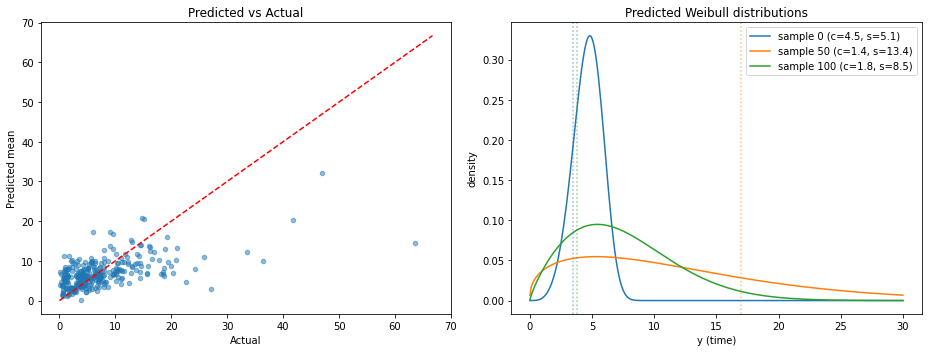

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
ax.scatter(Y_test, Y_pred, alpha=0.5, s=20)
lims = [0, max(Y_test.max(), Y_pred.max()) * 1.05]
ax.plot(lims, lims, "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted mean")
ax.set_title("Predicted vs Actual")

ax = axes[1]
x = np.linspace(0.01, 30, 300)
for i in [0, 50, 100]:
    c_i, s_i = dists.shape[i], dists.scale[i]
    pdf = scipy.stats.weibull_min.pdf(x, c=c_i, scale=s_i)
    ax.plot(x, pdf, label=f"sample {i} (c={c_i:.1f}, s={s_i:.1f})")
    ax.axvline(Y_test[i], color=ax.lines[-1].get_color(), linestyle=":", alpha=0.5)
ax.set_xlabel("y (time)")
ax.set_ylabel("density")
ax.set_title("Predicted Weibull distributions")
ax.legend()

plt.tight_layout()
plt.show()